In [9]:
from imports import *
from exactDiagMethods import *
from globalMethods import  *
from vqteMethods import *

In [10]:
N = 4

gamma_L= 4
gamma_R = 4

eps = 1
mu_L= 0.75
mu_R= 3
T_L = 100   
T_R= 10
beta_L=1/T_L
beta_R=1/T_R

F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)

J = 3


eps_list = []

for i in range(N):
    eps_list.append(1)

time = 6.0
dt = 0.3
nt = int(time/dt)

exact_diag_ham = build_exact_diag_hamiltonian(J, eps_list)

ham_real, ham_imag = hamiltonian_generation(N, eps_list, gamma_L, gamma_R, F_L, F_R, J)

vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)

exact_diag_results, superoperator = perform_exact_diag(gamma_L,F_L, gamma_R, F_R, dt, nt, exact_diag_init_state,exact_diag_ham, N)


In [11]:

"""
Compares the superoperator obtained from exact diagonalization
with the Hamiltonian constructed from VQTE components.

Inputs:
    superoperator : darray - The superoperator from exact diagonalization
    ham_real : SparsePauliOp - The real part of the Hamiltonian from VQTE
    ham_imag : SparsePauliOp - The imaginary part of the Hamiltonian from VQTE

Returns:
    difference : array - The difference between the two matrices
"""
vqte_hamiltonian = ham_real.to_matrix()- 1j * ham_imag.to_matrix()
difference = superoperator + (1j*vqte_hamiltonian)
print("Difference between superoperator and VQTE Hamiltonian:\n", difference)
print("Norm of the difference:", np.linalg.norm(difference))


Difference between superoperator and VQTE Hamiltonian:
 [[ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 ...
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
  -4.4408921e-16+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j -4.4408921e-16+0.j]]
Norm of the difference: 5.0242958677880805e-15


Norm of Hamiltonian part difference: 1.2560739669470201e-15
Norm of Dissipative part difference: 5.891509130072236e-15


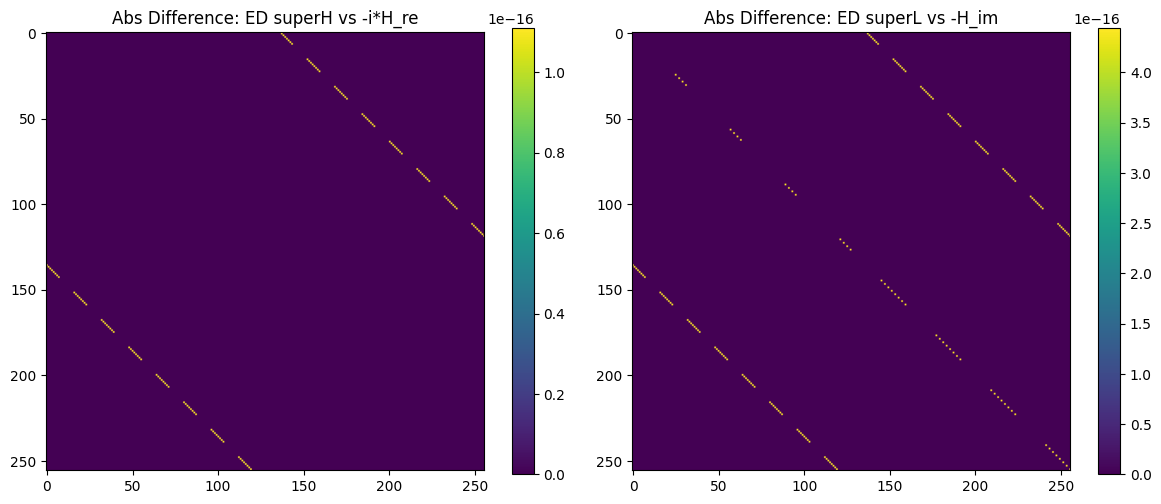

In [12]:
"""
    Builds superoperators from kron products and compares them against reference 
    real / imag exact matricies
    
    """
    #Hilbert space size
d = len(exact_diag_ham)

L_K = [ ##Operators 

    np.sqrt(gamma_L*F_L) * Enlarge_Matrix_site_j(0, N, Sigma_minus),
    np.sqrt(gamma_L*(1-F_L)) * Enlarge_Matrix_site_j(0, N, Sigma_plus),
    np.sqrt(gamma_R*(1-F_R)) * Enlarge_Matrix_site_j(N-1, N, Sigma_plus),
    np.sqrt(gamma_R*F_R) * Enlarge_Matrix_site_j(N-1, N, Sigma_minus)

]
##Construct superop
superH = (np.kron(np.eye(d), exact_diag_ham) - np.kron(exact_diag_ham.T, np.eye(d)))

superL = 1j* sum([np.kron(L.conjugate(), L)
              #jump term
              - 0.5 * (np.kron(np.eye(d), L.conjugate().T @ L) +
                #decay
                       np.kron(L.T @ L.conjugate(), np.eye(d))) for L in L_K])

#super H = realpart of H + real part of L (H + H_adj /2)
# Super H-H_adj/2i

L = superH+superL 
L_real = (L + L.H)/2

L_imag = (L - L.H)/2j


mat_re = ham_real.to_matrix()
mat_im = ham_imag.to_matrix()


diff_re = L_real - (mat_re)
diff_im = L_imag - (-1 * mat_im) # check signs

print(f"Norm of Hamiltonian part difference: {np.linalg.norm(diff_re)}")
print(f"Norm of Dissipative part difference: {np.linalg.norm(diff_im)}")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


im1 = axes[0].imshow(np.abs(diff_re), cmap='viridis')
axes[0].set_title("Abs Difference: ED superH vs -i*H_re")

plt.colorbar(im1, ax=axes[0])


im2 = axes[1].imshow(np.abs(diff_im), cmap='viridis')

axes[1].set_title("Abs Difference: ED superL vs -H_im")

plt.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()



In [13]:
#This function confirms that the VQTE and Classical Exact Diag produce the same initial state


vqte_matrix = vqte_init_state.data.reshape(16, 16, order='F')

overlap = np.real(np.trace(vqte_matrix.conj().T @ exact_diag_init_state))


print(f"Overlap between VQTE-derived matrix and Exact Diag initial state: {overlap}")

Overlap between VQTE-derived matrix and Exact Diag initial state: 1.0


Make operators into quantum circut. Brute force but (It could work)
Compose it in a quantum transpiler

## Email JJ
## Added working Test(1) to clean

## Erase from computer

Start a doc for tasks for this week 

Physical Review A[]

In [ ]:

## Check number operators for N qubits
N = 2
vqte_num_ops = custom_num_op(N)

exact_num_ops = build_number_op_list(N)



print(vqte_num_ops)
print("Exact:", exact_num_ops)


print("Num Op Check for Init State")
for i in range(N):
    print(f"Site {i+1}:")
    print(f"VQTE Expectation: {vqte_expectations[i]}")
    print(f"ED Expectation:  {ed_expectations[i]}")





[array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]), array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])]
Exact: [matrix([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]), matrix([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])]
Num Op Check for Init State
Site 1:
Site 1:


NameError: name 'vqte_expectations' is not defined

Norm of Hamiltonian part difference: 1.2560739669470201e-15
Norm of Dissipative part difference: 5.891509130072236e-15


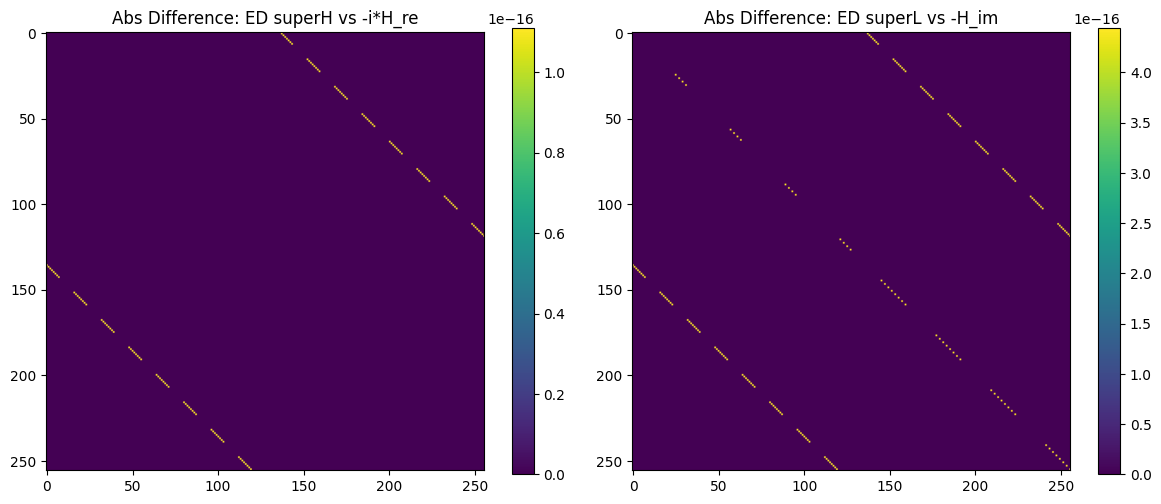

In [ ]:
"""
    Builds superoperators from kron products and compares them against reference 
    real / imag exact matricies
    
    """
    #Hilbert space size
d = len(exact_diag_ham)



superL = 1j* sum([np.kron(L.conjugate(), L)
              #jump term
              - 0.5 * (np.kron(np.eye(d), L.conjugate().T @ L) +
                #decay
                       np.kron(L.T @ L.conjugate(), np.eye(d))) for L in L_K])

#super H = realpart of H + real part of L (H + H_adj /2)
# Super H-H_adj/2i

L = superH+superL 
L_real = (L + L.H)/2

L_imag = (L - L.H)/2j


mat_re = ham_real.to_matrix()
mat_im = ham_imag.to_matrix()


diff_re = L_real - (mat_re)
diff_im = L_imag - (-1 * mat_im) # check signs

print(f"Norm of Hamiltonian part difference: {np.linalg.norm(diff_re)}")
print(f"Norm of Dissipative part difference: {np.linalg.norm(diff_im)}")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


im1 = axes[0].imshow(np.abs(diff_re), cmap='viridis')
axes[0].set_title("Abs Difference: ED superH vs -i*H_re")

plt.colorbar(im1, ax=axes[0])


im2 = axes[1].imshow(np.abs(diff_im), cmap='viridis')

axes[1].set_title("Abs Difference: ED superL vs -H_im")

plt.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()



In [ ]:
## If not, variational, norm

## How can i make the initial state more interesting?
## Look at what happens when I set gamme to 0
## I want to do bash again

## I will comment code on vqte better